# Alpha - Beta calculation

This notebook allows you to calculate the basic dimensionless alpha - beta parameters for a set of fireball data after [Gritsevich 2012](https://doi.org/???). This use the eponential atmosphere simplification. To use a complete atmosphere model for your fireball, please see [Lyytinen et al. 2016](https://doi.org/10.1016/j.pss.2015.10.012).

### Inputs:
csv file with following column headers:
+ velocity (or as indicated below)
+ height (or as indicated below)

### Outputs:
ecsv file with:
+ normalised height 
+ normalised velocity 
+ alpha and beta in metadata

###########################################################
## DO NOT change this section
Please just run the cells as they are.  To run code cells, select and press shift + enter

## Code imports
Let's start with code imports. To run code cells, select and press shift + enter

In [1]:
# import astropy
import scipy
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from astropy.table import Table
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import FileLinks, FileLink, DisplayObject

In [2]:
matplotlib inline

In [3]:
plt.rcParams['figure.dpi'] = 100

## Function definitions

In [4]:
def Q4_min(Vvalues, Yvalues):
    """ initiates and calls the Q4 minimisation given in Gritsevich 2007 -
        'Validity of the photometric formula for estimating the mass of a fireball projectile'
    """
    params = np.vstack((Vvalues, Yvalues))

    b0 = 1.
    a0 = np.exp(Yvalues[-1])/(2. * b0)
    x0 = [a0, b0]
    xmin = [0.001, 0.00001]
    xmax = [10000., 50.]

    bnds = ((xmin[0], xmax[0]), (xmin[1], xmax[1]))

    res = minimize(min_fun, x0, args=(Vvalues, Yvalues),bounds=bnds)
    return res.x    

In [5]:
def min_fun(x, vvals, yvals):
    """minimises equation 7 using Q4 minimisation given in equation 10 of 
       Gritsevich 2007 - 'Validity of the photometric formula for estimating 
       the mass of a fireball projectile'

    """ 
    res = 0.
    for i in range(len(vvals)):
        res += pow(2 * x[0] * np.exp(-yvals[i]) - (scipy.special.expi(x[1]) - scipy.special.expi(x[1]* vvals[i]**2) ) * np.exp(-x[1]) , 2)
    #       #sum...alpha*e^-y*2                     |__________________-del______________________________________|     *e^-beta    
        # res += (np.log(2 * x[0]) -yvals[i] - np.log(scipy.special.expi(x[1]) - scipy.special.expi(x[1]* vvals[i]**2) ) -x[1]) * 2
    return res

###########################################################

## Upload data
Now provide the path to the csv file 

In [6]:
# @interact
# def show_files(dir=os.listdir('/home/ellie/Desktop/Data')):
#     f =FileLinks(dir, included_suffixes=".csv")


In [7]:
f = 'DN150417.csv'
slope = 15.17

If you would like to define an initial velocity, insert below. Otherwise, an average of first 10 data points will be used.

In [30]:
v0 = []

If you would like to change the default header names, insert here:

In [34]:
vel_col = "D_DT_geo"
h_col = "height"

######################################################
## Just run the below!

In [35]:
data = Table.read(f, format='ascii.csv', guess=False, delimiter=',')
slope = np.deg2rad(slope)

## Normalising data
This is where we create the dimensionless data. We create separate columns to mask nan/zero values.

Height is normalised using the scale  height of the homogeneous atmosphere (h0=7160 km). Velocity is normalised using the initial velocity. Here we crudly use the average of the first 10 data points. For more sophisticated v0 determination, you may hardcode in the v0 value you wish to use here:

In [36]:
alt = []#np.asarray(data['height'])
vel = []#np.asarray(data['D_DT_geo'])

# remove any nan values
for v in range(len(data[vel_col])):
    if data[vel_col][v] >1.:
        vel.append(data[vel_col][v])
        alt.append(data[h_col][v])
        
# define initial velocity, if not already
if v0 == []:
    v0 = np.nanmean(vel[0:10])

# normalise velocity
vel = np.asarray(vel)
alt = np.asarray(alt)
Vvalues = vel/v0      #creates a matrix of V/Ve to give a dimensionless parameter for velocity


# normalise height - if statement accounts for km vs. metres data values.
if alt[0]<1000:
    h0 = 7.160  # km
else:
    h0 = 7160.  # metres
Yvalues = alt/h0  

## Calculate alpha and beta
This calls the Q4_min function from below. Make sure you have compile 

In [37]:
Gparams= Q4_min(Vvalues, Yvalues)

alpha = Gparams[0]
beta = Gparams[1]

Alpha and Beta values are (respectively):

In [38]:
print(alpha, beta)

294.451599359 1.14005615987


## Plotting

In [39]:
plt.close()
# plt.rcParams['figure.dpi'] = 10
plt.rcParams['figure.figsize'] = [5, 5]

In [40]:
x = np.arange(0.1,1, 0.00005);                                                                                     #create a matrix of x values
fun = lambda x:np.log(alpha) + beta - np.log((scipy.special.expi(beta) - scipy.special.expi(beta* x**2) )/2)
y = [fun(i) for i in x]

In [41]:
plt.scatter(Vvalues, Yvalues,marker='x', label=None)  
plt.xlabel("normalised velocity")
plt.ylabel("normalised height")
plt.plot(x, y, color='r')
# plt.xlim(0.4, 1.23)
# plt.ylim(6, 12)
plt.show()

## Using alpha and beta to estimate masses

if your point is:  
right of the _grey_ line --> unlikely meteorite  
left of the _black_ line  --> likely meteorite  
in between two lines --> possible meteorite  

In [24]:
plt.close()
plt.rcParams['figure.figsize'] = [7, 7]

/home/ellie/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in log
/home/ellie/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log
/home/ellie/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in log


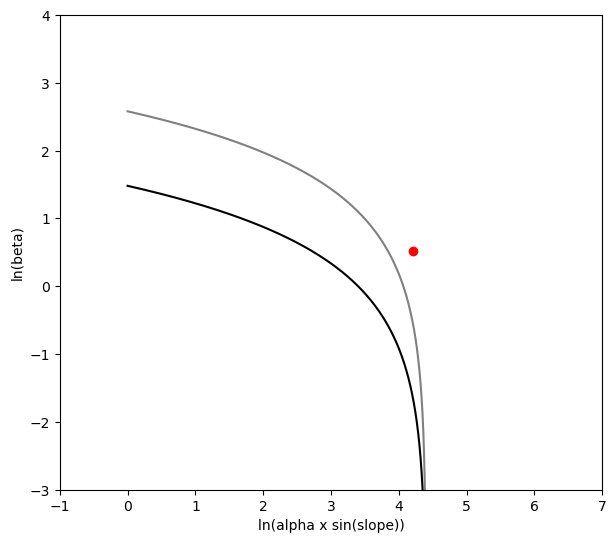

In [25]:
# define x values
x_mu = np.arange(0,10, 0.00005)

# function for mu = 0, 50 g possible meteorite:
fun_mu0 = lambda x_mu:np.log(13.2 - 3*x_mu)
y_mu0 = [fun_mu0(i) for i in x_mu]

# function for mu = 2/3, 50 g possible meteorite:
fun_mu23 = lambda x_mu:np.log(4.4 - x_mu)
y_mu23 = [fun_mu23(i) for i in x_mu]

# plot mu0, mu2/3 lines and your poit:
plt.plot(x_mu, y_mu0, color='grey')
plt.plot(x_mu, y_mu23, color='k')
plt.scatter([np.log(alpha * np.sin(slope))], [np.log(beta)], color='r')

# defite plot parameters
plt.xlim((-1, 7))
plt.ylim((-3, 4))
plt.xlabel("ln(alpha x sin(slope))")
plt.ylabel("ln(beta)")
plt.axes().set_aspect('equal')
plt.show()

## Have a play with parameters!
masses are in grams

In [79]:
plt.close()
plt.rcParams['figure.figsize'] = [7, 7]

/home/ellie/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in log


0.000432363763473


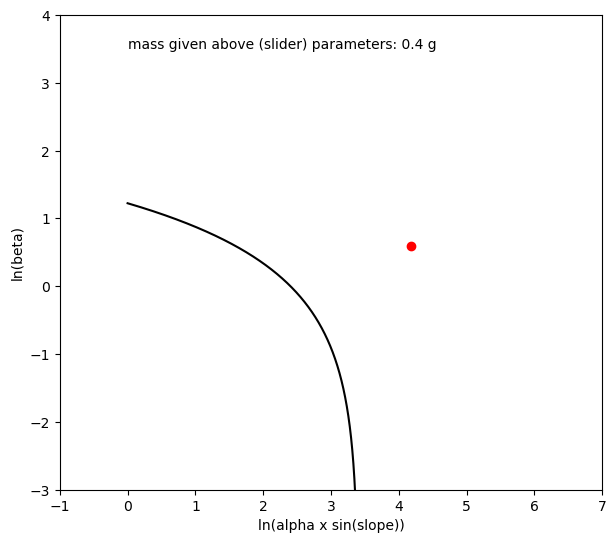

In [80]:
plt.close()
def f(mf, mu, cd, rho, A):
    rho = float(rho)
    A = float(A)
    mf = mf/1000.
    m0 = (0.5 * cd * 1.29 * 7160. * A / pow(rho, 2/3))**3.
    x = np.arange(0,10, 0.00005)
    y = [np.log((mu - 1) * (np.log(mf/m0) + 3 * i)) for i in x]
    
    plt.plot(x, y, color='k')
    
    plt.scatter([np.log(alpha * np.sin(slope))], [np.log(beta)], color='r')
    m_txt=pow(0.5 *  cd * 1.29 * 7160. * A / (alpha * np.sin(slope) *rho**(2/3.0)), 3.0) *np.exp(-beta/(1-mu))
    print(m_txt)

    plt.xlim((-1, 7))
    plt.ylim((-3, 4))
    plt.axes().set_aspect('equal')
    plt.text(0, 3.5, "mass given above (slider) parameters: %.1f g" %(m_txt * 1000) )#, ha='center', va='center', transform=ax.transAxes)

    plt.xlabel("ln(alpha x sin(slope))")
    plt.ylabel("ln(beta)")
    plt.show()

interact(f, mf=(0, 2000, 500), mu=(0, 2/3., 1/3.), cd=(0.9, 1.5), rho=[1500,2700,3500,7000], A=[1.21, 1.5, 2.0, 3.0])


In [81]:
## Assumeing values:
# atmospheric density at sea level
sea_level_rho = 1.29
# AERODYNAMIC drag coefficient (not Gamma)
cd = 1.3
# Possible shape coefficients
A = [1.21, 1.3, 1.55]
# possible meteoroid densities
m_rho = [2700, 3500, 7000]
# trajectory slope
gamma = slope
sin_gamma = np.sin(gamma)
# shape change coefficient
mu = 2./3.

me_sphere = [pow(0.5 *  cd * 1.29 * 7160 * A[0] / (alpha * sin_gamma *i**(2/3.0)), 3.0) for i in m_rho]
me_round_brick = [pow(0.5 *  cd * 1.29 * 7160 * A[1] / (alpha * sin_gamma *i**(2/3.0)), 3.0) for i in m_rho]
me_brick = [pow(0.5 *  cd * 1.29 * 7160 * A[2] / (alpha * sin_gamma * i**(2/3.0)), 3.0) for i in m_rho]
mf_sphere = [i * np.exp(-beta / (1-mu) *(1-Vvalues[-1]**2)) for i in me_sphere]
mf_round_brick = [i * np.exp(-beta / (1-mu) *(1-Vvalues[-1]**2)) for i in me_round_brick]
mf_brick = [i * np.exp(-beta / (1-mu) *(1-Vvalues[-1]**2)) for i in me_brick]


### Spherical body:

In [82]:
print("Entry mass of spherical body with 3500 density =\n", me_sphere[1])
print("\n")
print("Final mass of spherical body with 3500 density =\n",mf_sphere[1])

Entry mass of spherical body with 3500 density =
 0.11225499407


Final mass of spherical body with 3500 density =
 0.00474181246588


### Rounded brick body (typical):

In [83]:
print("Entry mass of typical shape with 3500 density =\n", me_round_brick[1])
print("\n")
print("Final mass of typical shape with 3500 density =\n",mf_round_brick[1])

Entry mass of typical shape with 3500 density =
 0.139212943823


Final mass of typical shape with 3500 density =
 0.00588055505147


### Brick body:

In [67]:
print("Entry mass of brick shape with 3500 density =\n", me_brick[1])
print("\n")
print("Final mass of brick shape with 3500 density =\n",mf_brick[1])

Entry mass of brick shape with 3500 density =
 0.23596340518


Final mass of brick shape with 3500 density =
 0.00996743374705


In [ ]:
out = astropy.table.Table(names=['alt', 'vels'], data=[alt, vel])

In [ ]:
out.write('/tmp/test.csv', format='csv', delimiter=',')

################################